In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import scipy.stats as stats
import pickle
import os
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import xgboost
from sklearn.linear_model import ElasticNet
import re
import sys
from time import sleep
from tqdm.notebook import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import joblib
import json
%matplotlib inline

In [2]:
df = pd.read_csv('datasets_20710_26737_Bengaluru_House_Data.csv')

# EDA

In [3]:
df.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13320 entries, 0 to 13319
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   area_type     13320 non-null  object 
 1   availability  13320 non-null  object 
 2   location      13319 non-null  object 
 3   size          13304 non-null  object 
 4   society       7818 non-null   object 
 5   total_sqft    13320 non-null  object 
 6   bath          13247 non-null  float64
 7   balcony       12711 non-null  float64
 8   price         13320 non-null  float64
dtypes: float64(3), object(6)
memory usage: 936.7+ KB


In [5]:
df.describe()

,bath,balcony,price
count,13247.000000,12711.000000,13320.000000
mean,2.692610,1.584376,112.565627
std,1.341458,0.817263,148.971674
min,1.000000,0.000000,8.000000
25%,2.000000,1.000000,50.000000
50%,2.000000,2.000000,72.000000
75%,3.000000,2.000000,120.000000
max,40.000000,3.000000,3600.000000


##### A huge difference between 75% and max values can be seen

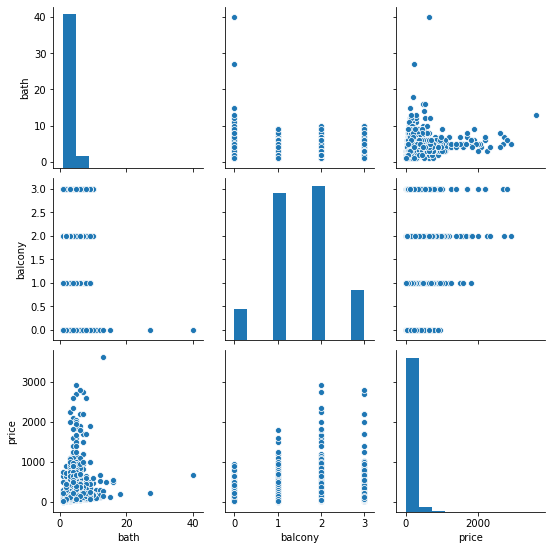

In [6]:
sns.pairplot(df)

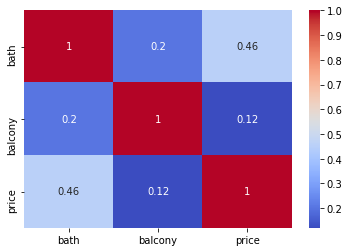

In [7]:
#coorelation heatmap
num_vars = ["bath", "balcony", "price"]
sns.heatmap(df[num_vars].corr(),cmap="coolwarm", annot=True)

### Observations
*  total_sqft    13320 non-null  object is supposed to be of float64 type 
*  size          13304 non-null  object is supposed to be of float64/int32 type
* No strong linear coorelation observed between price and other float64 type variables

# Data Cleaning


In [8]:
df.isnull().sum()

area_type          0
availability       0
location           1
size              16
society         5502
total_sqft         0
bath              73
balcony          609
price              0
dtype: int64

In [9]:
df.isnull().mean()*100

area_type        0.000000
availability     0.000000
location         0.007508
size             0.120120
society         41.306306
total_sqft       0.000000
bath             0.548048
balcony          4.572072
price            0.000000
dtype: float64

* 41% of values in society are of null type and hence can be removed 

In [10]:
df.drop('society', inplace=True, axis = 1)
df.head()

,area_type,availability,location,size,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,1200,2.0,1.0,51.00


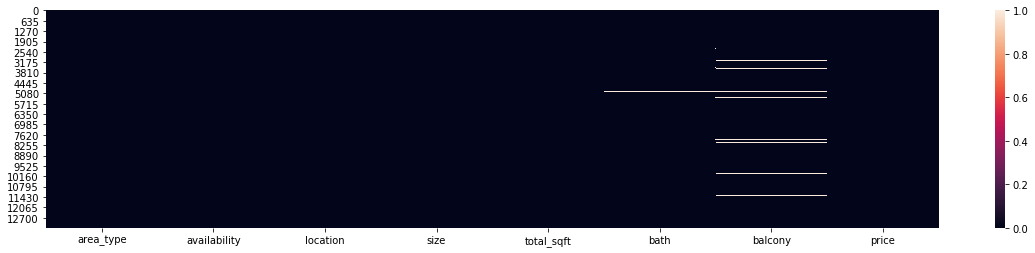

In [11]:
plt.figure(figsize=(20,4))
sns.heatmap(df.isnull())

In [12]:
df['balcony'] = df['balcony'].fillna(df['balcony'].mean())

* Null values in balcony are replaced by mean of the feature. Grouping by location and then replacing it by mean of the group can also be used to subsitute Null values

In [13]:
df.isnull().mean()*100

area_type       0.000000
availability    0.000000
location        0.007508
size            0.120120
total_sqft      0.000000
bath            0.548048
balcony         0.000000
price           0.000000
dtype: float64

* Since, less than 1% of the values are null, they can  be dropped

In [14]:
df.dropna(inplace  = True)

In [15]:
df.head()

,area_type,availability,location,size,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,1200,2.0,1.0,51.00


In [16]:
df.isnull().sum()

area_type       0
availability    0
location        0
size            0
total_sqft      0
bath            0
balcony         0
price           0
dtype: int64

In [17]:
"""Function to change total_sqft feature to float64 type"""
def change_to_float(area_size):
    if isinstance(area_size, str):
        area_size = area_size.split('Sq.')[0]
        area_size = area_size.split('Perch')[0]
        area_size = area_size.split('Acres')[0]
        area_size = area_size.split('Guntha')[0]
        area_size = area_size.split('Grounds')[0]
        area_size = area_size.split('Cents')[0]
        area_size = area_size.split('-')
        area_size = np.mean(list(map(float, area_size)))
    return area_size
df['total_sqft'] = df['total_sqft'].apply(lambda x: change_to_float(x))
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13246 entries, 0 to 13319
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   area_type     13246 non-null  object 
 1   availability  13246 non-null  object 
 2   location      13246 non-null  object 
 3   size          13246 non-null  object 
 4   total_sqft    13246 non-null  float64
 5   bath          13246 non-null  float64
 6   balcony       13246 non-null  float64
 7   price         13246 non-null  float64
dtypes: float64(4), object(4)
memory usage: 931.4+ KB


In [18]:
df.head()

,area_type,availability,location,size,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,1056.0,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,2600.0,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,1440.0,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,1521.0,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,1200.0,2.0,1.0,51.00


In [19]:
df['size'].value_counts().head()

2 BHK        5198
3 BHK        4286
4 Bedroom     818
4 BHK         577
3 Bedroom     546
Name: size, dtype: int64

In [20]:
"""Changing size to float64 type"""
df['size'] = df['size'].apply(lambda x : x.split()[0])

In [21]:
df['size'] = df['size'].astype(float)
df.dtypes

area_type        object
availability     object
location         object
size            float64
total_sqft      float64
bath            float64
balcony         float64
price           float64
dtype: object

### Dealing with outliers

In [22]:
def diagnostic_plots(df, variable):
    # function takes a dataframe (df) and
    # the variable of interest as arguments
 
    # define figure size
    plt.figure(figsize=(16, 4))
 
    # histogram
    plt.subplot(1, 3, 1)
    sns.distplot(df[variable], bins=30)
    plt.title('Histogram')
 
    # Q-Q plot
    plt.subplot(1, 3, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.ylabel('Variable quantiles')
 
    # boxplot
    plt.subplot(1, 3, 3)
    sns.boxplot(y=df[variable])
    plt.title('Boxplot')
 
    plt.show()

******* bath *******


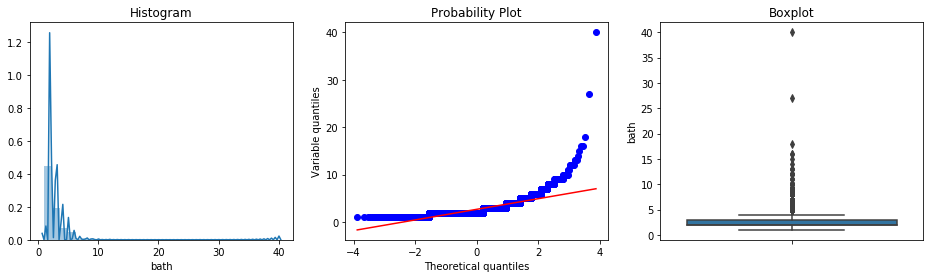

******* balcony *******


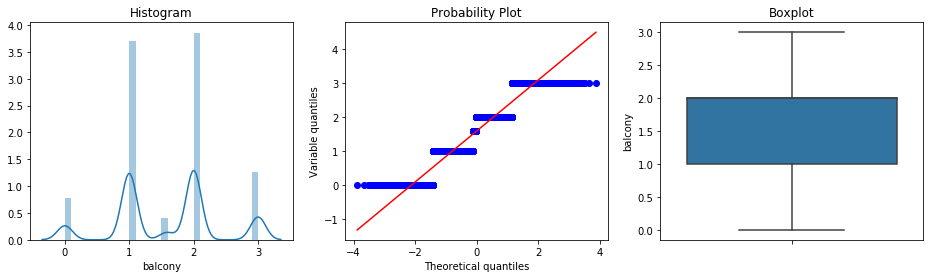

******* total_sqft *******


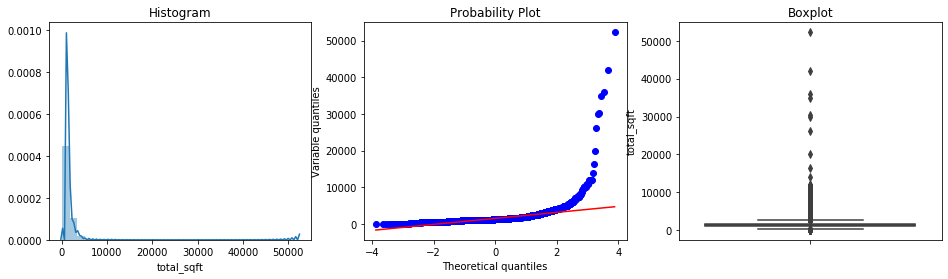

******* size *******


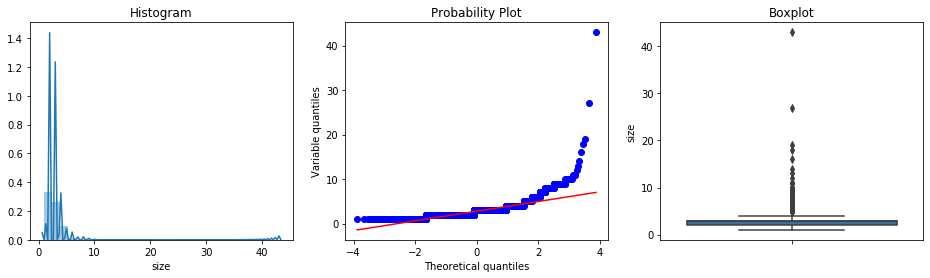

******* price *******


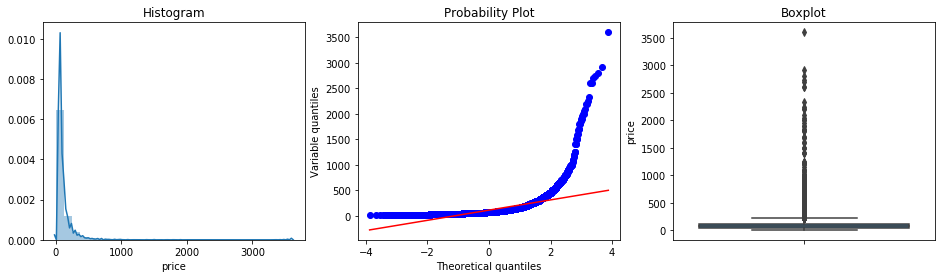

In [23]:
num_var = ["bath","balcony","total_sqft","size","price"]
for var in num_var:
    print("******* {} *******".format(var))
    diagnostic_plots(df, var)

In [24]:
df[df['total_sqft']/df['size'] < 350].head() # A flat is atleast of 350 square feet in a city like Bangalore

,area_type,availability,location,size,total_sqft,bath,balcony,price
9,Plot Area,Ready To Move,Gandhi Bazar,6.0,1020.0,6.0,1.584376,370.0
26,Super built-up Area,Ready To Move,Electronic City,2.0,660.0,1.0,1.000000,23.1
29,Super built-up Area,Ready To Move,Electronic City,3.0,1025.0,2.0,1.000000,47.0
45,Plot Area,Ready To Move,HSR Layout,8.0,600.0,9.0,1.584376,200.0
58,Plot Area,Ready To Move,Murugeshpalya,6.0,1407.0,4.0,1.000000,150.0


In [25]:
len(df[df['total_sqft']/df['size'] < 350])

1132

In [26]:
n = len(df)
df = df[~(df['total_sqft']/df['size'] < 350)]
print("% of rows remaining {} %".format(len(df)*100/n)) 

% of rows remaining 91.45402385625849 %


In [27]:
df['price_per_square_foot'] = df['price']*100000/df['total_sqft']
df['price_per_square_foot'].describe()

count     12114.000000
mean       6184.331613
std        4018.909796
min         267.829813
25%        4200.158497
50%        5261.108523
75%        6800.000000
max      176470.588235
Name: price_per_square_foot, dtype: float64

###### Again a huge difference between 75th percentile and maximum value can be observed


In [28]:
def remove_values_greater_than_1_sd(df):
    df_out = pd.DataFrame()
    for key, subdf in df.groupby('location'):
        m=np.mean(subdf.price_per_square_foot)
        st=np.std(subdf.price_per_square_foot)
        reduced_df = subdf[(subdf.price_per_square_foot>(m-st)) & (subdf.price_per_square_foot<=(m+st))]
        df_out = pd.concat([df_out, reduced_df], ignore_index = True)
    return df_out

df = remove_values_greater_than_1_sd(df)

In [29]:
df.shape

(8897, 9)

In [30]:
df['bath'].describe()

count    8897.000000
mean        2.454535
std         0.925621
min         1.000000
25%         2.000000
50%         2.000000
75%         3.000000
max        12.000000
Name: bath, dtype: float64

In [31]:
#Let's group by location, find mean,std and count of size of houses in that location. If mean of 2bhk > 1bhk, remove it .
exclude = np.array([])
for location, location_df in df.groupby('location'):
    statss = {}
    for size, size_df in location_df.groupby('size'):
        
        statss[size] = {
            'mean': np.mean(size_df.price_per_square_foot),
            'count': size_df.shape[0]
        }
        print(statss)
    
    for size, size_df in location_df.groupby('size'):
        prev = statss.get(size-1)
        if prev and prev['count'] > 5:
            exclude = np.append(exclude, size_df[size_df.price_per_square_foot < (prev['mean'])].index.values)
        

{3.0: {'mean': 8685.668717247665, 'count': 3}}
{2.0: {'mean': 4278.151140436048, 'count': 8}}
{2.0: {'mean': 4278.151140436048, 'count': 8}, 3.0: {'mean': 4404.02899440667, 'count': 5}}
{1.0: {'mean': 4909.090909090909, 'count': 1}}
{1.0: {'mean': 3642.8571428571427, 'count': 1}}
{1.0: {'mean': 3642.8571428571427, 'count': 1}, 3.0: {'mean': 4827.586206896552, 'count': 1}}
{1.0: {'mean': 6363.636363636364, 'count': 1}}
{1.0: {'mean': 4950.980392156863, 'count': 2}}
{3.0: {'mean': 20000.0, 'count': 1}}
{3.0: {'mean': 5519.480519480519, 'count': 1}}
{1.0: {'mean': 7500.0, 'count': 1}}
{1.0: {'mean': 7500.0, 'count': 1}, 4.0: {'mean': 4761.9047619047615, 'count': 1}}
{2.0: {'mean': 5360.0, 'count': 1}}
{2.0: {'mean': 11983.805668016194, 'count': 1}}
{2.0: {'mean': 11983.805668016194, 'count': 1}, 3.0: {'mean': 11756.16905248807, 'count': 3}}
{2.0: {'mean': 11983.805668016194, 'count': 1}, 3.0: {'mean': 11756.16905248807, 'count': 3}, 4.0: {'mean': 15018.711280365416, 'count': 3}}
{2.0: {'m

{2.0: {'mean': 6454.091928430547, 'count': 5}}
{2.0: {'mean': 6454.091928430547, 'count': 5}, 3.0: {'mean': 6572.746532916982, 'count': 19}}
{2.0: {'mean': 6454.091928430547, 'count': 5}, 3.0: {'mean': 6572.746532916982, 'count': 19}, 4.0: {'mean': 7684.086312870249, 'count': 2}}
{2.0: {'mean': 7063.829787234043, 'count': 1}}
{2.0: {'mean': 7063.829787234043, 'count': 1}, 3.0: {'mean': 6192.187874430865, 'count': 2}}
{1.0: {'mean': 4020.618556701031, 'count': 1}}
{1.0: {'mean': 4020.618556701031, 'count': 1}, 2.0: {'mean': 4953.838379629301, 'count': 12}}
{1.0: {'mean': 4020.618556701031, 'count': 1}, 2.0: {'mean': 4953.838379629301, 'count': 12}, 3.0: {'mean': 5574.846418310635, 'count': 7}}
{2.0: {'mean': 4831.868131868132, 'count': 3}}
{2.0: {'mean': 5017.247111628294, 'count': 2}}
{2.0: {'mean': 5017.247111628294, 'count': 2}, 3.0: {'mean': 9446.617670301881, 'count': 2}}
{2.0: {'mean': 5833.333333333333, 'count': 1}}
{2.0: {'mean': 5833.333333333333, 'count': 1}, 3.0: {'mean': 621

{2.0: {'mean': 6630.037324398989, 'count': 4}}
{2.0: {'mean': 6630.037324398989, 'count': 4}, 3.0: {'mean': 7565.595658950089, 'count': 4}}
{2.0: {'mean': 6630.037324398989, 'count': 4}, 3.0: {'mean': 7565.595658950089, 'count': 4}, 4.0: {'mean': 8300.132802124834, 'count': 1}}
{1.0: {'mean': 4932.455648926237, 'count': 5}}
{1.0: {'mean': 4932.455648926237, 'count': 5}, 2.0: {'mean': 5156.7223242312, 'count': 59}}
{1.0: {'mean': 4932.455648926237, 'count': 5}, 2.0: {'mean': 5156.7223242312, 'count': 59}, 3.0: {'mean': 5384.498056381959, 'count': 71}}
{1.0: {'mean': 4932.455648926237, 'count': 5}, 2.0: {'mean': 5156.7223242312, 'count': 59}, 3.0: {'mean': 5384.498056381959, 'count': 71}, 4.0: {'mean': 6221.05665959561, 'count': 7}}
{1.0: {'mean': 4932.455648926237, 'count': 5}, 2.0: {'mean': 5156.7223242312, 'count': 59}, 3.0: {'mean': 5384.498056381959, 'count': 71}, 4.0: {'mean': 6221.05665959561, 'count': 7}, 5.0: {'mean': 5851.851851851852, 'count': 1}}
{2.0: {'mean': 4922.058482801

{1.0: {'mean': 2558.3277187022322, 'count': 17}}
{1.0: {'mean': 2558.3277187022322, 'count': 17}, 2.0: {'mean': 2746.8339259134063, 'count': 31}}
{1.0: {'mean': 2558.3277187022322, 'count': 17}, 2.0: {'mean': 2746.8339259134063, 'count': 31}, 3.0: {'mean': 2719.4945813606732, 'count': 21}}
{1.0: {'mean': 8426.966292134832, 'count': 1}}
{1.0: {'mean': 8426.966292134832, 'count': 1}, 3.0: {'mean': 9364.583333333334, 'count': 4}}
{2.0: {'mean': 3613.5088756107502, 'count': 24}}
{2.0: {'mean': 3613.5088756107502, 'count': 24}, 3.0: {'mean': 4500.644242719408, 'count': 9}}
{2.0: {'mean': 3613.5088756107502, 'count': 24}, 3.0: {'mean': 4500.644242719408, 'count': 9}, 4.0: {'mean': 5963.333333333333, 'count': 1}}
{2.0: {'mean': 3613.5088756107502, 'count': 24}, 3.0: {'mean': 4500.644242719408, 'count': 9}, 4.0: {'mean': 5963.333333333333, 'count': 1}, 6.0: {'mean': 4285.714285714285, 'count': 1}}
{2.0: {'mean': 3895.0450283511836, 'count': 2}}
{2.0: {'mean': 3895.0450283511836, 'count': 2}, 3

{1.0: {'mean': 9445.779914529914, 'count': 3}, 2.0: {'mean': 7329.742881854468, 'count': 3}}
{1.0: {'mean': 9445.779914529914, 'count': 3}, 2.0: {'mean': 7329.742881854468, 'count': 3}, 3.0: {'mean': 8601.445470741792, 'count': 14}}
{2.0: {'mean': 17777.777777777777, 'count': 1}}
{2.0: {'mean': 3359.08630601346, 'count': 5}}
{3.0: {'mean': 8512.633414125952, 'count': 3}}
{3.0: {'mean': 6618.723028377738, 'count': 3}}
{2.0: {'mean': 4500.0, 'count': 1}}
{2.0: {'mean': 4500.0, 'count': 1}, 3.0: {'mean': 4333.333333333333, 'count': 1}}
{2.0: {'mean': 5918.727915194347, 'count': 1}}
{2.0: {'mean': 6352.512219589275, 'count': 7}}
{2.0: {'mean': 6352.512219589275, 'count': 7}, 3.0: {'mean': 6961.117262886345, 'count': 8}}
{2.0: {'mean': 6352.512219589275, 'count': 7}, 3.0: {'mean': 6961.117262886345, 'count': 8}, 4.0: {'mean': 6621.198451923327, 'count': 3}}
{2.0: {'mean': 6040.350024307243, 'count': 2}}
{2.0: {'mean': 6040.350024307243, 'count': 2}, 3.0: {'mean': 6375.30193236715, 'count': 

{1.0: {'mean': 3822.222222222222, 'count': 2}}
{2.0: {'mean': 6966.502769732227, 'count': 34}}
{2.0: {'mean': 6966.502769732227, 'count': 34}, 3.0: {'mean': 7011.896703425919, 'count': 57}}
{2.0: {'mean': 6966.502769732227, 'count': 34}, 3.0: {'mean': 7011.896703425919, 'count': 57}, 4.0: {'mean': 7863.9440401577685, 'count': 22}}
{2.0: {'mean': 8716.498778998779, 'count': 4}}
{2.0: {'mean': 8716.498778998779, 'count': 4}, 3.0: {'mean': 9517.562179481964, 'count': 13}}
{2.0: {'mean': 8716.498778998779, 'count': 4}, 3.0: {'mean': 9517.562179481964, 'count': 13}, 4.0: {'mean': 8861.240238842134, 'count': 4}}
{2.0: {'mean': 8716.498778998779, 'count': 4}, 3.0: {'mean': 9517.562179481964, 'count': 13}, 4.0: {'mean': 8861.240238842134, 'count': 4}, 5.0: {'mean': 8320.802005012532, 'count': 3}}
{2.0: {'mean': 6157.975113248077, 'count': 5}}
{2.0: {'mean': 6157.975113248077, 'count': 5}, 3.0: {'mean': 6681.438863622023, 'count': 27}}
{2.0: {'mean': 6157.975113248077, 'count': 5}, 3.0: {'mean'

{2.0: {'mean': 5957.446808510638, 'count': 1}}
{2.0: {'mean': 5957.446808510638, 'count': 1}, 3.0: {'mean': 12222.222222222223, 'count': 1}}
{4.0: {'mean': 17777.777777777777, 'count': 1}}
{2.0: {'mean': 11419.99141999142, 'count': 2}}
{2.0: {'mean': 11419.99141999142, 'count': 2}, 3.0: {'mean': 12324.824986537427, 'count': 2}}
{2.0: {'mean': 5833.333333333333, 'count': 1}}
{2.0: {'mean': 8683.232233876743, 'count': 2}}
{2.0: {'mean': 8683.232233876743, 'count': 2}, 3.0: {'mean': 6896.551724137931, 'count': 1}}
{2.0: {'mean': 5380.205408855938, 'count': 19}}
{2.0: {'mean': 5380.205408855938, 'count': 19}, 3.0: {'mean': 5118.341784477213, 'count': 22}}
{2.0: {'mean': 7083.333333333333, 'count': 1}}
{3.0: {'mean': 7196.969696969697, 'count': 1}}
{4.0: {'mean': 5916.666666666667, 'count': 1}}
{2.0: {'mean': 4351.406771578446, 'count': 2}}
{2.0: {'mean': 4351.406771578446, 'count': 2}, 3.0: {'mean': 6895.570698128242, 'count': 5}}
{2.0: {'mean': 4351.406771578446, 'count': 2}, 3.0: {'mean'

{1.0: {'mean': 3250.0, 'count': 1}}
{1.0: {'mean': 3250.0, 'count': 1}, 2.0: {'mean': 3285.4634212085666, 'count': 7}}
{1.0: {'mean': 3250.0, 'count': 1}, 2.0: {'mean': 3285.4634212085666, 'count': 7}, 3.0: {'mean': 3203.254608294931, 'count': 5}}
{2.0: {'mean': 8239.947264337508, 'count': 1}}
{2.0: {'mean': 8239.947264337508, 'count': 1}, 3.0: {'mean': 8604.468160292936, 'count': 3}}
{4.0: {'mean': 3708.3333333333335, 'count': 1}}
{3.0: {'mean': 5833.333333333333, 'count': 1}}
{2.0: {'mean': 2963.386078194849, 'count': 2}}
{2.0: {'mean': 5651.459593313968, 'count': 4}}
{2.0: {'mean': 5651.459593313968, 'count': 4}, 3.0: {'mean': 6424.80445112024, 'count': 3}}
{1.0: {'mean': 4000.0, 'count': 1}}
{1.0: {'mean': 4000.0, 'count': 1}, 2.0: {'mean': 4464.71665687586, 'count': 10}}
{1.0: {'mean': 4000.0, 'count': 1}, 2.0: {'mean': 4464.71665687586, 'count': 10}, 3.0: {'mean': 4663.38431038836, 'count': 6}}
{1.0: {'mean': 4000.0, 'count': 1}, 2.0: {'mean': 4464.71665687586, 'count': 10}, 3.0:

{2.0: {'mean': 4778.701173252796, 'count': 8}}
{2.0: {'mean': 4778.701173252796, 'count': 8}, 3.0: {'mean': 5557.259722141612, 'count': 5}}
{2.0: {'mean': 5825.454545454545, 'count': 1}}
{2.0: {'mean': 5825.454545454545, 'count': 1}, 3.0: {'mean': 4897.959183673469, 'count': 1}}
{2.0: {'mean': 4450.0450218933265, 'count': 10}}
{2.0: {'mean': 4450.0450218933265, 'count': 10}, 3.0: {'mean': 4425.035578878555, 'count': 4}}
{1.0: {'mean': 11278.58331782561, 'count': 4}}
{1.0: {'mean': 11278.58331782561, 'count': 4}, 2.0: {'mean': 9844.198787438378, 'count': 9}}
{1.0: {'mean': 11278.58331782561, 'count': 4}, 2.0: {'mean': 9844.198787438378, 'count': 9}, 3.0: {'mean': 12896.335169301065, 'count': 22}}
{1.0: {'mean': 11278.58331782561, 'count': 4}, 2.0: {'mean': 9844.198787438378, 'count': 9}, 3.0: {'mean': 12896.335169301065, 'count': 22}, 4.0: {'mean': 11241.379310344826, 'count': 3}}
{1.0: {'mean': 11278.58331782561, 'count': 4}, 2.0: {'mean': 9844.198787438378, 'count': 9}, 3.0: {'mean': 

{2.0: {'mean': 5044.765086152552, 'count': 2}}
{2.0: {'mean': 5044.765086152552, 'count': 2}, 3.0: {'mean': 4978.265998965327, 'count': 2}}
{2.0: {'mean': 6488.103629335819, 'count': 8}}
{2.0: {'mean': 6488.103629335819, 'count': 8}, 3.0: {'mean': 7732.476289952065, 'count': 3}}
{2.0: {'mean': 6488.103629335819, 'count': 8}, 3.0: {'mean': 7732.476289952065, 'count': 3}, 4.0: {'mean': 7400.652269436281, 'count': 19}}
{2.0: {'mean': 5660.295741126656, 'count': 17}}
{2.0: {'mean': 5660.295741126656, 'count': 17}, 3.0: {'mean': 5877.4699494233955, 'count': 17}}
{2.0: {'mean': 5660.295741126656, 'count': 17}, 3.0: {'mean': 5877.4699494233955, 'count': 17}, 4.0: {'mean': 5568.646870314652, 'count': 10}}
{2.0: {'mean': 5660.295741126656, 'count': 17}, 3.0: {'mean': 5877.4699494233955, 'count': 17}, 4.0: {'mean': 5568.646870314652, 'count': 10}, 5.0: {'mean': 6125.232403718459, 'count': 2}}
{4.0: {'mean': 8864.903747345345, 'count': 2}}
{2.0: {'mean': 7011.686143572621, 'count': 1}}
{2.0: {'me

{3.0: {'mean': 6528.189910979228, 'count': 1}}
{5.0: {'mean': 20000.0, 'count': 1}}
{2.0: {'mean': 9403.409090909092, 'count': 2}}
{2.0: {'mean': 9403.409090909092, 'count': 2}, 3.0: {'mean': 10322.58064516129, 'count': 1}}
{2.0: {'mean': 9403.409090909092, 'count': 2}, 3.0: {'mean': 10322.58064516129, 'count': 1}, 4.0: {'mean': 11111.111111111111, 'count': 1}}
{2.0: {'mean': 8110.300081103001, 'count': 1}}
{2.0: {'mean': 8110.300081103001, 'count': 1}, 3.0: {'mean': 10473.320144245747, 'count': 5}}
{2.0: {'mean': 8110.300081103001, 'count': 1}, 3.0: {'mean': 10473.320144245747, 'count': 5}, 4.0: {'mean': 10168.067226890757, 'count': 1}}
{1.0: {'mean': 4615.384615384615, 'count': 1}}
{1.0: {'mean': 4615.384615384615, 'count': 1}, 2.0: {'mean': 5994.141111942159, 'count': 2}}
{1.0: {'mean': 4615.384615384615, 'count': 1}, 2.0: {'mean': 5994.141111942159, 'count': 2}, 3.0: {'mean': 3965.432098765432, 'count': 2}}
{2.0: {'mean': 6983.618233618235, 'count': 3}}
{2.0: {'mean': 6983.61823361

{1.0: {'mean': 4998.3598840688865, 'count': 2}}
{1.0: {'mean': 4998.3598840688865, 'count': 2}, 2.0: {'mean': 4451.776042086879, 'count': 6}}
{1.0: {'mean': 4998.3598840688865, 'count': 2}, 2.0: {'mean': 4451.776042086879, 'count': 6}, 3.0: {'mean': 4706.376756380032, 'count': 5}}
{2.0: {'mean': 3333.3333333333335, 'count': 1}}
{4.0: {'mean': 8437.5, 'count': 1}}
{2.0: {'mean': 3548.1171548117154, 'count': 1}}
{2.0: {'mean': 4714.285714285715, 'count': 1}}
{3.0: {'mean': 13796.296296296296, 'count': 1}}
{3.0: {'mean': 34290.90909090909, 'count': 1}}
{2.0: {'mean': 5555.555555555556, 'count': 2}}
{2.0: {'mean': 5555.555555555556, 'count': 2}, 3.0: {'mean': 6469.4915254237285, 'count': 2}}
{2.0: {'mean': 4471.544715447155, 'count': 1}}
{2.0: {'mean': 4471.544715447155, 'count': 1}, 4.0: {'mean': 4751.461988304093, 'count': 1}}
{3.0: {'mean': 9419.191919191919, 'count': 2}}
{2.0: {'mean': 7281.553398058252, 'count': 1}}
{2.0: {'mean': 7281.553398058252, 'count': 1}, 4.0: {'mean': 15750.0,

In [32]:
n = len(df)
print("Shape before removing outliers {}".format(n))
df.drop(exclude, axis = 0,inplace = True)
print("Shape after removing outliers {}".format(df.shape))

Shape before removing outliers 8897
Shape after removing outliers (7203, 9)


In [33]:
df['bath'].unique()

array([ 3.,  2.,  1.,  4.,  5.,  8.,  9.,  6.,  7., 12.])

In [34]:
df = df[df.bath < df.size +2]
df.shape

(7203, 9)

******* bath *******


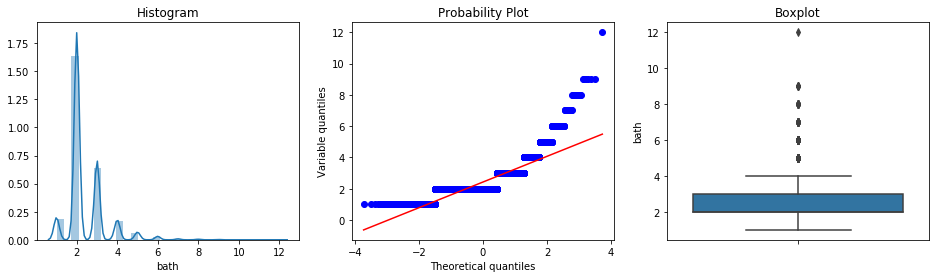

******* balcony *******


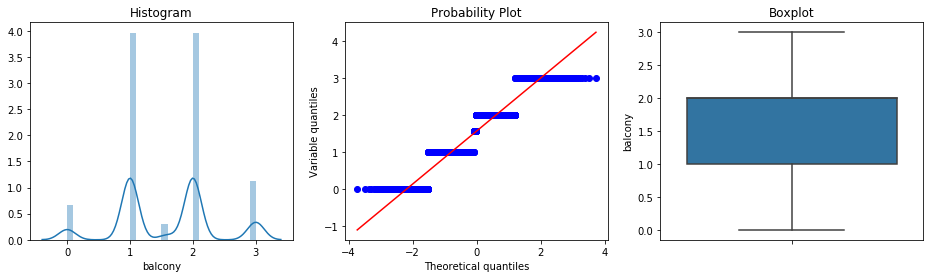

******* total_sqft *******


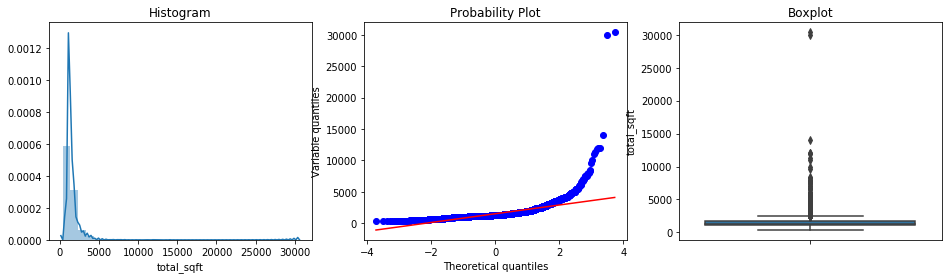

******* size *******


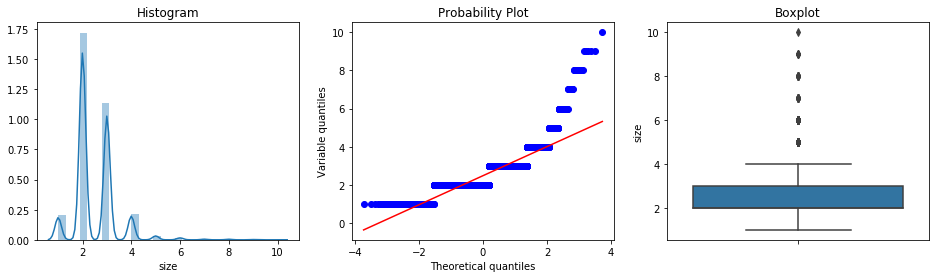

******* price *******


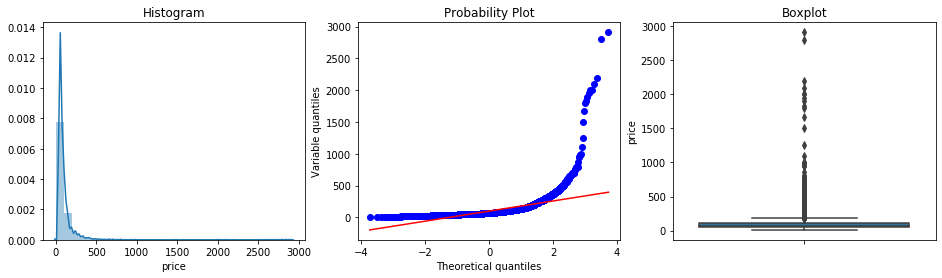

In [35]:
num_var = ["bath","balcony","total_sqft","size","price"]
for var in num_var:
    print("******* {} *******".format(var))
    diagnostic_plots(df, var)

* It is rare to find a house with more than 6/7 bedrooms in an urban city

******* bath *******


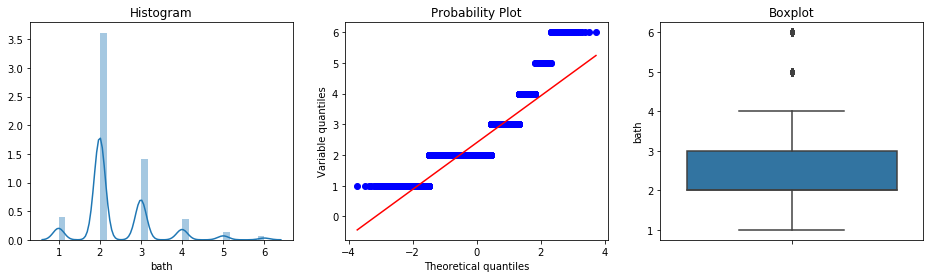

******* size *******


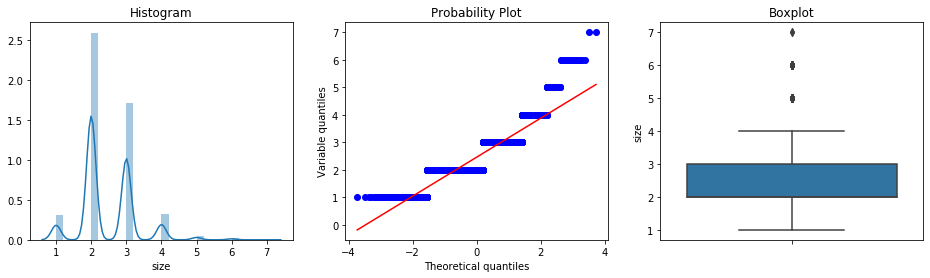

In [36]:
df = df.drop(df[df['bath']>6].index)
df = df.drop(df[df['size']>7.0].index)
num_var = ["bath","size"]
for var in num_var:
    print("******* {} *******".format(var))
    diagnostic_plots(df, var)

In [37]:
df.head()

,area_type,availability,location,size,total_sqft,bath,balcony,price,price_per_square_foot
0,Super built-up Area,Ready To Move,Devarabeesana Halli,3.0,1672.0,3.0,2.0,150.0,8971.291866
1,Built-up Area,Ready To Move,Devarabeesana Halli,3.0,1750.0,3.0,3.0,149.0,8514.285714
2,Super built-up Area,Ready To Move,Devarabeesana Halli,3.0,1750.0,3.0,2.0,150.0,8571.428571
4,Super built-up Area,Ready To Move,Devarachikkanahalli,2.0,1250.0,2.0,2.0,40.0,3200.000000
5,Plot Area,Ready To Move,Devarachikkanahalli,2.0,1200.0,2.0,2.0,83.0,6916.666667


In [38]:
df.drop('area_type',axis = 1, inplace=True)
df.head()

,availability,location,size,total_sqft,bath,balcony,price,price_per_square_foot
0,Ready To Move,Devarabeesana Halli,3.0,1672.0,3.0,2.0,150.0,8971.291866
1,Ready To Move,Devarabeesana Halli,3.0,1750.0,3.0,3.0,149.0,8514.285714
2,Ready To Move,Devarabeesana Halli,3.0,1750.0,3.0,2.0,150.0,8571.428571
4,Ready To Move,Devarachikkanahalli,2.0,1250.0,2.0,2.0,40.0,3200.000000
5,Ready To Move,Devarachikkanahalli,2.0,1200.0,2.0,2.0,83.0,6916.666667


* If the house is ready to move, then the row is replaced by 1, else by 0

In [39]:
df['is_ready'] = np.where(df['availability'] == "Ready To Move",1,0)
df.drop('availability',axis = 1, inplace = True)
df.head()

,location,size,total_sqft,bath,balcony,price,price_per_square_foot,is_ready
0,Devarabeesana Halli,3.0,1672.0,3.0,2.0,150.0,8971.291866,1
1,Devarabeesana Halli,3.0,1750.0,3.0,3.0,149.0,8514.285714,1
2,Devarabeesana Halli,3.0,1750.0,3.0,2.0,150.0,8571.428571,1
4,Devarachikkanahalli,2.0,1250.0,2.0,2.0,40.0,3200.000000,1
5,Devarachikkanahalli,2.0,1200.0,2.0,2.0,83.0,6916.666667,1


In [40]:
df['location'].value_counts().describe()

count    741.000000
mean       9.663968
std       19.603824
min        1.000000
25%        2.000000
50%        3.000000
75%        9.000000
max      237.000000
Name: location, dtype: float64

* All locations with less than 10 properties are put in the "other" category

In [41]:
#print("Shape before removing rows: {}".format(df.shape))
location_count = df.groupby('location')['location'].agg('count')
location_count_less_than_10 = location_count[location_count<=10]
df['location'] = df['location'].apply(lambda x: "other" if x in location_count_less_than_10 else x)
#print("Shape after removing rows: {}".format(df.shape))

In [42]:
df['location'].value_counts().describe()

count     165.000000
mean       43.400000
std       142.840044
min        11.000000
25%        15.000000
50%        23.000000
75%        34.000000
max      1820.000000
Name: location, dtype: float64

In [43]:
df.head()

,location,size,total_sqft,bath,balcony,price,price_per_square_foot,is_ready
0,other,3.0,1672.0,3.0,2.0,150.0,8971.291866,1
1,other,3.0,1750.0,3.0,3.0,149.0,8514.285714,1
2,other,3.0,1750.0,3.0,2.0,150.0,8571.428571,1
4,Devarachikkanahalli,2.0,1250.0,2.0,2.0,40.0,3200.000000,1
5,Devarachikkanahalli,2.0,1200.0,2.0,2.0,83.0,6916.666667,1


In [44]:
df.shape

(7161, 8)

In [45]:
df = df[df.location != 'other']
df['location'].value_counts()

Whitefield         237
Sarjapur  Road     187
Electronic City    158
Haralur Road       116
Marathahalli       116
                  ... 
Murugeshpalya       11
Yelachenahalli      11
HRBR Layout         11
Nagavara            11
Banaswadi           11
Name: location, Length: 164, dtype: int64

In [46]:
df.shape

(5341, 8)

* A house with 'n' bedrooms has at max 'n+1' bathrooms

In [47]:
df = df[df.bath<df.size+2]
df.shape

(5341, 8)

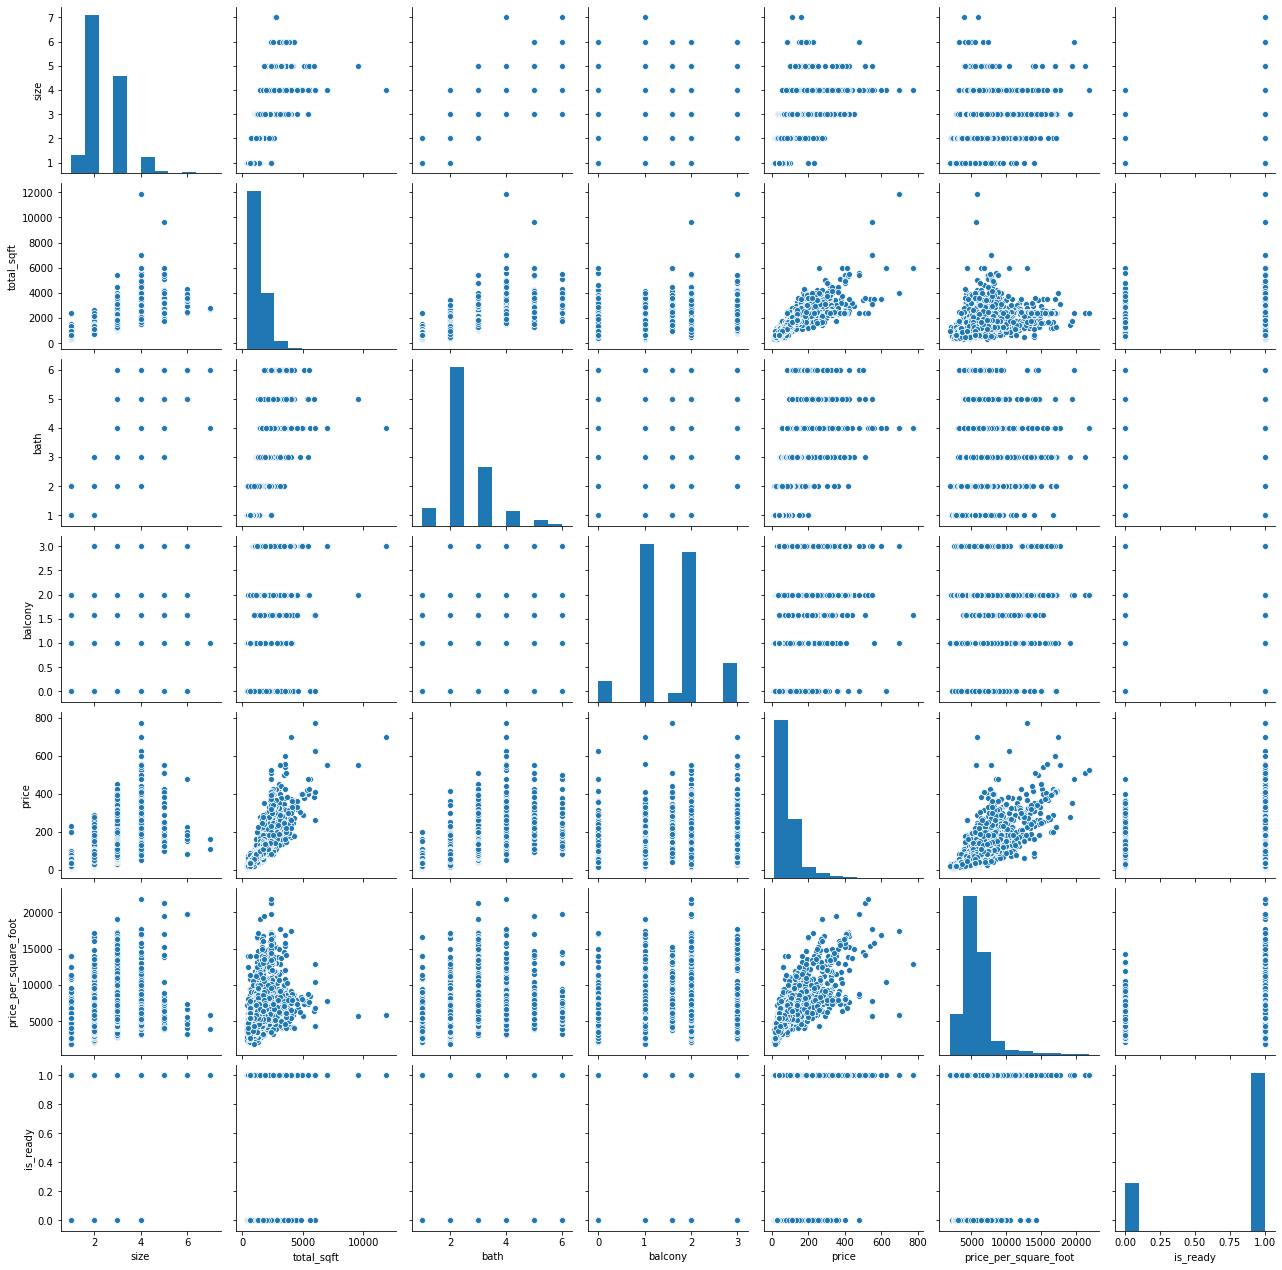

In [48]:
sns.pairplot(df)

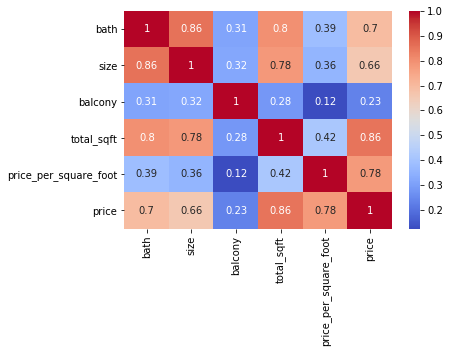

In [49]:
num_vars = ["bath", "size", "balcony", "total_sqft", "price_per_square_foot","price"]
sns.heatmap(df[num_vars].corr(),cmap="coolwarm", annot=True)

* A strong linear relationship is observed between price, price_per_square_foot and total_sqft.(also size ~ good linear relation)

##### One-hot encoding the locations

In [50]:
dummies = pd.get_dummies(df['location'], drop_first=True)
dummies.head()

,1st Phase JP Nagar,5th Phase JP Nagar,6th Phase JP Nagar,7th Phase JP Nagar,8th Phase JP Nagar,9th Phase JP Nagar,Abbigere,Akshaya Nagar,Ambalipura,Ambedkar Nagar,...,Uttarahalli,Varthur,Vidyaranyapura,Vijayanagar,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yeshwanthpur
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [51]:
df = pd.concat([df,dummies], axis = 1)
df.head()

,location,size,total_sqft,bath,balcony,price,price_per_square_foot,is_ready,1st Phase JP Nagar,5th Phase JP Nagar,...,Uttarahalli,Varthur,Vidyaranyapura,Vijayanagar,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yeshwanthpur
4,Devarachikkanahalli,2.0,1250.0,2.0,2.0,40.0,3200.000000,1,0,0,...,0,0,0,0,0,0,0,0,0,0
5,Devarachikkanahalli,2.0,1200.0,2.0,2.0,83.0,6916.666667,1,0,0,...,0,0,0,0,0,0,0,0,0,0
6,Devarachikkanahalli,2.0,1170.0,2.0,2.0,40.0,3418.803419,1,0,0,...,0,0,0,0,0,0,0,0,0,0
7,Devarachikkanahalli,3.0,1425.0,2.0,2.0,65.0,4561.403509,1,0,0,...,0,0,0,0,0,0,0,0,0,0
8,Devarachikkanahalli,2.0,947.0,2.0,2.0,43.0,4540.654699,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [52]:
df.drop('location', inplace=True, axis = 1)
df.head()

,size,total_sqft,bath,balcony,price,price_per_square_foot,is_ready,1st Phase JP Nagar,5th Phase JP Nagar,6th Phase JP Nagar,...,Uttarahalli,Varthur,Vidyaranyapura,Vijayanagar,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yeshwanthpur
4,2.0,1250.0,2.0,2.0,40.0,3200.000000,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,2.0,1200.0,2.0,2.0,83.0,6916.666667,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,2.0,1170.0,2.0,2.0,40.0,3418.803419,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,3.0,1425.0,2.0,2.0,65.0,4561.403509,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,2.0,947.0,2.0,2.0,43.0,4540.654699,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [53]:
df = df.drop(columns=['balcony','price_per_square_foot'])
df.head()

,size,total_sqft,bath,price,is_ready,1st Phase JP Nagar,5th Phase JP Nagar,6th Phase JP Nagar,7th Phase JP Nagar,8th Phase JP Nagar,...,Uttarahalli,Varthur,Vidyaranyapura,Vijayanagar,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yeshwanthpur
4,2.0,1250.0,2.0,40.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,2.0,1200.0,2.0,83.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,2.0,1170.0,2.0,40.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,3.0,1425.0,2.0,65.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,2.0,947.0,2.0,43.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


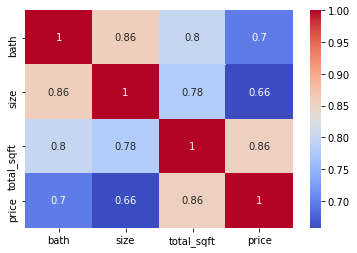

In [54]:
num_vars = ["bath", "size", "total_sqft","price"]
sns.heatmap(df[num_vars].corr(),cmap="coolwarm", annot=True)

In [55]:
df.reset_index(drop = True, inplace=True)
df.head()

,size,total_sqft,bath,price,is_ready,1st Phase JP Nagar,5th Phase JP Nagar,6th Phase JP Nagar,7th Phase JP Nagar,8th Phase JP Nagar,...,Uttarahalli,Varthur,Vidyaranyapura,Vijayanagar,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yeshwanthpur
0,2.0,1250.0,2.0,40.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2.0,1200.0,2.0,83.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2.0,1170.0,2.0,40.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3.0,1425.0,2.0,65.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2.0,947.0,2.0,43.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [56]:
df.to_csv('one_hot_data.csv', index = False)

In [57]:
X = df.drop('price',axis = 1)
y = df.price
print(X.shape)
print(y.shape)

(5341, 167)
(5341,)


In [58]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 51)
print('Shape of X_train = ', X_train.shape)
print('Shape of y_train = ', y_train.shape)
print('Shape of X_test = ', X_test.shape)
print('Shape of y_test = ', y_test.shape)

Shape of X_train =  (4272, 167)
Shape of y_train =  (4272,)
Shape of X_test =  (1069, 167)
Shape of y_test =  (1069,)


In [59]:
sc = StandardScaler()
sc.fit(X_train)
X_train= sc.transform(X_train)
X_test = sc.transform(X_test)

In [60]:
lr_clf = LinearRegression()
lr_clf.fit(X_train,y_train)
lr_clf.score(X_test,y_test)

0.8974440121334651

In [61]:
clf = Lasso()
clf.fit(X_train,y_train)
clf.score(X_test,y_test)

0.8766290880394446

In [ ]:
"""def find_best_linear_model(X, Y, tqdm=tqdm):
    algos = {
        'Linear_regression' : {
            'model' : LinearRegression(),
            'params': {
                'normalize':[True, False]
             }
          },  
         'Lasso' : {
             'model': Lasso(),
             'params': {
                  "max_iter": [1, 5, 10],
                 'alpha': [0.02, 0.024, 0.025, 0.026, 0.03, 0.05, 0.5, 1,2],
                 'selection':['random', 'cyclic'],
                  'normalize':[True, False]
             }
          },
         'Ridge' : {
             'model' : Ridge(),
             'params': {
                  "max_iter": [1, 5, 10],
                 'alpha': [0.05, 0.1, 0.5, 1, 5, 10, 200, 230, 250,265, 270, 275, 290, 300, 500],
                  'normalize':[True, False]
             }
         },
        'ElasticNet' : {
             'model' : ElasticNet(),
             'params' : {
                 "max_iter": [1, 5, 10],
                 'alpha': [0, 0.01, 0.02, 0.03, 0.05, 0.5, 1, 0.05, 0.1, 0.5, 1, 5, 10, 100],
                 'l1_ratio': np.arange(0.0, 1.0, 0.1),
                 'normalize':[True, False]
             } 
         }
    }
    values = (algos.items())
    scores = []
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
    print(f'Grid Search CV Initiated..' )    
    with tqdm(total=len(values), file=sys.stdout) as pbar:
        for algo_name, config in algos.items():
            pbar.set_description('Processed')
            gs =  GridSearchCV(config['model'], config['params'], cv=cv, return_train_score=False)
            gs.fit(X,Y)
            scores.append({
                'model': algo_name,
                'best_score': gs.best_score_,
                'best_params': gs.best_params_
            })
            pbar.update(1)
            print(f'Grid search CV for {algo_name} done')
        print("Grid Search CV completed!")
    return pd.DataFrame(scores,columns=['model','best_score','best_params'])
"""

In [ ]:
"""def find_best_tree_model(X, Y, tqdm=tqdm):
    
    algos = {
          'Decision_tree': {
              'model': DecisionTreeRegressor(),
              'params': {
                  'criterion' : ['mse', 'friedman_mse'],
                  'splitter': ['best', 'random']
              }
          }
        
    }
    values = (algos.items())
    scores = []
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
    print(f'Grid Search CV Initiated..' )    
    with tqdm(total=len(values), file=sys.stdout) as pbar:
        for algo_name, config in algos.items():
            pbar.set_description('Processed')
            gs =  GridSearchCV(config['model'], config['params'], cv=cv, return_train_score=False)
            gs.fit(X,Y)
            scores.append({
                'model': algo_name,
                'best_score': gs.best_score_,
                'best_params': gs.best_params_
            })
            pbar.update(1)
            print(f'Grid search CV for {algo_name} done')
        print("Grid Search CV completed!")
    return pd.DataFrame(scores,columns=['model','best_score','best_params'])"""

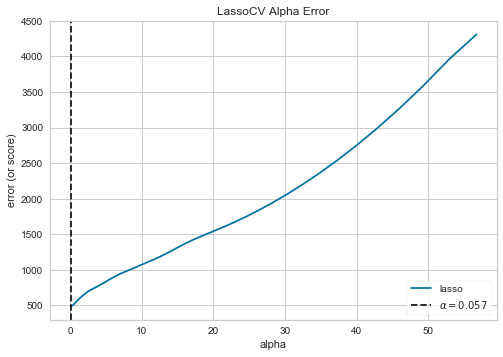

AlphaSelection(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x000002080C6FE288>,
               is_fitted='auto', model=None)

In [62]:
from yellowbrick.regressor import AlphaSelection
from sklearn.linear_model import LassoCV
from yellowbrick.regressor.alphas import alphas
alphas(LassoCV(random_state=0), X_train, y_train)

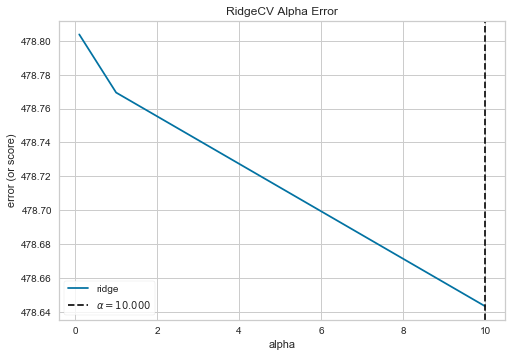

AlphaSelection(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x000002080BD3FEC8>,
               is_fitted='auto', model=None)

In [63]:
from yellowbrick.regressor import AlphaSelection
from sklearn.linear_model import RidgeCV
from yellowbrick.regressor.alphas import alphas
alphas(RidgeCV(), X_train, y_train)

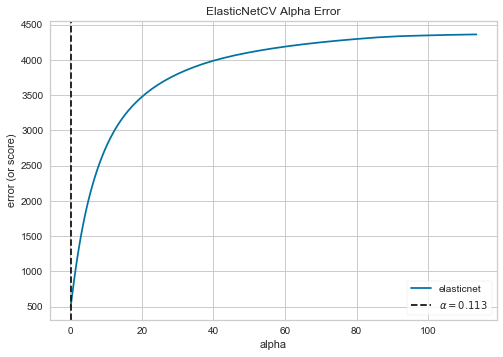

AlphaSelection(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x000002080C8A54C8>,
               is_fitted='auto', model=None)

In [64]:
from yellowbrick.regressor import AlphaSelection
from sklearn.linear_model import ElasticNetCV
from yellowbrick.regressor.alphas import alphas
alphas(ElasticNetCV(random_state=0), X_train, y_train)

In [65]:
clf = Ridge(alpha=10)
clf.fit(X_train,y_train)
clf.score(X_test,y_test)

0.8970637833639372

In [66]:
clf = Lasso(alpha=0.057)
clf.fit(X_train,y_train)
clf.score(X_test,y_test)

0.8971624974057578

In [67]:
clf = ElasticNet(alpha=0.113)
clf.fit(X_train,y_train)
clf.score(X_test,y_test)

0.8874262366972794

In [68]:
svr = SVR()
svr.fit(X_train,y_train)
svr.score(X_test,y_test)

0.31290970899447346

In [69]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score

cv = ShuffleSplit(n_splits=5, test_size=0.2)
cross_val_score(Ridge(alpha=10),X,y,cv=cv)

array([0.86923073, 0.87731333, 0.88590805, 0.85909061, 0.86425436])

In [70]:
cross_val_score(Lasso(alpha=0.057),X,y,cv=cv)

array([0.88411796, 0.87125062, 0.88306219, 0.84778375, 0.87806314])

In [71]:
model_1 = Ridge(alpha=10)
model_1.fit(X_train,y_train)
y_pred = model_1.predict(X_test)
r2_score(y_pred,y_test)

0.8765083495498174

In [72]:
model_2 = Lasso(alpha=0.057)
model_2.fit(X_train,y_train)
y_pred = model_2.predict(X_test)
r2_score(y_pred,y_test)

0.8760610773898265

In [73]:
model_3 =  ElasticNet(alpha=0.113)
model_3.fit(X_train,y_train)
y_pred = model_3.predict(X_test)
r2_score(y_pred,y_test)

0.8554460847329669

In [74]:
model = Ridge(alpha=10)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
r2_score(y_pred,y_test)

0.8765083495498174

In [75]:
df1 = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df1 = df1.head(25)

In [76]:
df1.head()

,Actual,Predicted
1245,44.00,42.662952
4803,42.00,38.962316
168,36.94,43.349321
10,40.00,45.416416
492,81.00,80.375583


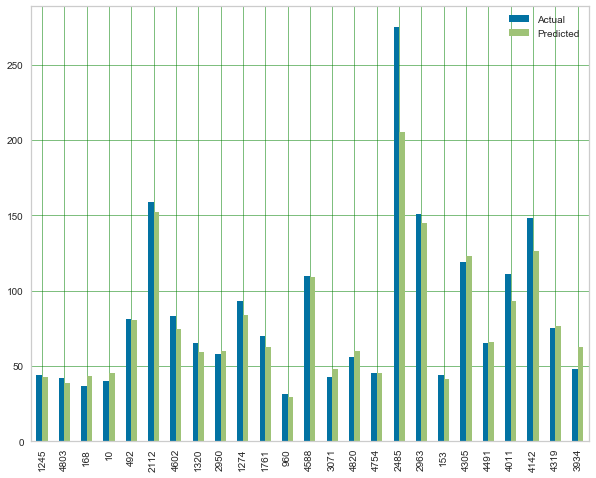

In [77]:
df1.plot(kind='bar',figsize=(10,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

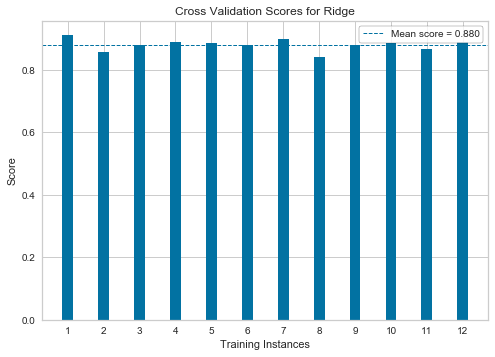

In [79]:
from yellowbrick.model_selection import CVScores
cv = ShuffleSplit(n_splits = 12)
viz_model = Ridge(alpha=10)
visualizer = CVScores(model, cv=cv, scoring='r2')

visualizer.fit(X, y)        # Fit the data to the visualizer
visualizer.show() 

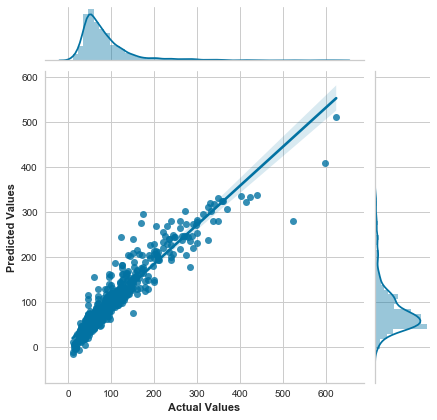

In [80]:
graph = sns.jointplot(x = y_test, y= y_pred, kind = "reg")
graph.set_axis_labels('Actual Values', 'Predicted Values', fontweight = 'bold')

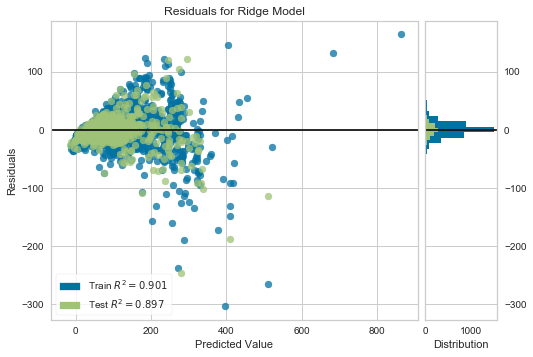

In [81]:
from yellowbrick.regressor import ResidualsPlot
visualize_model = Ridge(alpha=10)
visualizer = ResidualsPlot(visualize_model)
visualizer.fit(X_train, y_train)  
visualizer.score(X_test, y_test)
visualizer.show() 

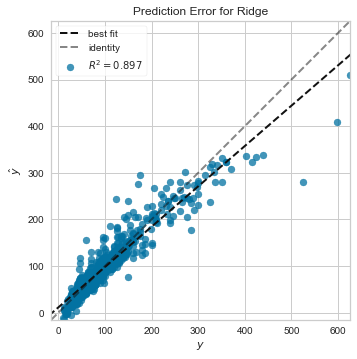

In [82]:
from yellowbrick.regressor import PredictionError
visualize_model = Ridge(alpha=10)
visualizer = PredictionError(visualize_model)
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show()   

In [83]:
X.head()

,size,total_sqft,bath,is_ready,1st Phase JP Nagar,5th Phase JP Nagar,6th Phase JP Nagar,7th Phase JP Nagar,8th Phase JP Nagar,9th Phase JP Nagar,...,Uttarahalli,Varthur,Vidyaranyapura,Vijayanagar,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yeshwanthpur
0,2.0,1250.0,2.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2.0,1200.0,2.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2.0,1170.0,2.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3.0,1425.0,2.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2.0,947.0,2.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


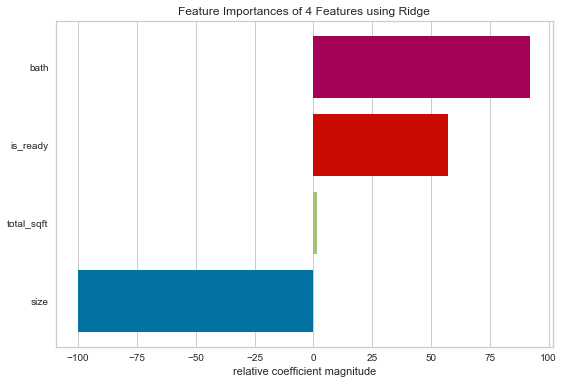

In [84]:
from yellowbrick.model_selection import FeatureImportances
visualize_model = Ridge(alpha=10)
viz = FeatureImportances(visualize_model)
viz.fit(X.iloc[:,:4],y)
viz.show()

In [85]:
print(" Mean absolute error on test set is {}".format(mean_absolute_error(y_test,y_pred)))
print(" Mean squared error on test set is {}".format(mean_squared_error(y_test,y_pred)))
print(" Root Mean squared error on test set is {}".format(np.sqrt(mean_absolute_error(y_test,y_pred))))
print(" R2 score on test set is {}".format(r2_score(y_test,y_pred)))

 Mean absolute error on test set is 12.212716786361167
 Mean squared error on test set is 457.74827416450086
 Root Mean squared error on test set is 3.494669767855207
 R2 score on test set is 0.8970637833639372


In [86]:
def predict_price(size, total_sqft, bath,is_ready,location,data = X):
    x = np.zeros(len(X.columns))
    loc_index = np.where(data.columns==location)[0][0]
    x[0] = size
    x[1] = total_sqft
    x[2] = bath
    x[3] = is_ready
    x = sc.transform([x])[0]
    if loc_index >= 0:
        x[loc_index] = 1
    return model.predict([x])[0]

In [87]:
predict_price(2,3500,2,0,"Sarjapur  Road") 

232.37170996517517

In [88]:
predict_price(2,3500,3,1,"Sarjapur")

230.8345166199249

In [89]:
predict_price(1,1000,2,0,"Indira Nagar")

55.292040902340666

In [90]:
from sklearn.externals import joblib
joblib.dump(model,'external_joblib_price')

['external_joblib_price']

In [91]:
with open('bangalore_house_prices.pickle','wb') as f:
    pickle.dump(model,f)

In [92]:
joblib.dump(model,'bangalore_house_prices_joblib.pkl')

['bangalore_house_prices_joblib.pkl']

In [93]:
columns = {
    'data_columns' : [col.lower() for col in X.columns]
}
with open('columns.json', 'w') as f:
    f.write(json.dumps(columns))